#Classifying with RDM matrix for 800 models

The question: how much information do input RDMs contain? Is this information enough to train a simple classifier to predict a model performance from its input RDM?

The answer: yes

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
import urllib.request
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

ROOT_PATH = 'gdrive/My Drive/NI Project - RSA/'

In [0]:
with open (ROOT_PATH + 'rdm800.pkl', 'rb') as fp:
    rdm = pickle.load(fp)
    
with open (ROOT_PATH + 'acc_list.pkl', 'rb') as fp:
    acc_list = pickle.load(fp)
    
with open (ROOT_PATH + 'corr_distances_dict800.pkl', 'rb') as fp:
    corr_distances_dict = pickle.load(fp)

In the RDM models are sorted in accordance with increasing accuracy

In [0]:
acc_only = np.array(np.array(acc_list)[:, 0], dtype='float32')
files_only = np.array(np.array(acc_list)[:, 1])

acc_sorted_idx = np.argsort(acc_only)
acc_sorted = acc_only[acc_sorted_idx]
files_sorted = files_only[acc_sorted_idx]
n = len(acc_sorted)

In [0]:
rdms = np.ones((n, 19900)) * -17 # num of models * linearised upper triangle of input rdm
for i in range(n):
  cur_corr_distances = corr_distances_dict[files_sorted[i]]
  cur_input_rdm = cur_corr_distances[np.triu_indices(cur_corr_distances.shape[0], k = 1)]
  rdms[i] = cur_input_rdm
  
seed = 42


##Classification

Classification doesn't work well, but we do through away information when constructing classes.

In [0]:
labels = (acc_sorted * 10)//1
X_train, X_test, y_train, y_test = train_test_split(rdms, labels, test_size=0.2, random_state=seed, shuffle=True)

In [0]:
print(X_train.shape)
print(y_train.shape)

(636, 19900)
(636,)


In [0]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=seed)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
print('Train')
print(clf.score(X_train, y_train))
print('Test')
print(clf.score(X_test, y_test))

Train
0.5283018867924528
Test
0.5283018867924528


In [0]:
for i in range(n):
#   print(rdms[i].shape)
#   print(np.expand_dims(rdms[i], axis=0).shape)
  print(clf.predict(np.expand_dims(rdms[i], axis=0)))

##Regression

Regression works well

In [0]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [0]:
X_train, X_test, y_train, y_test = train_test_split(rdms, acc_sorted, test_size=0.2, random_state=seed, shuffle=True)

In [0]:
print(X_train.shape)
print(y_train.shape)

(636, 19900)
(636,)


In [0]:
# regr = linear_model.LinearRegression(normalize=True)
# regr = MLPRegressor(hidden_layer_sizes=(50, 50, 20), verbose=True)
regr = linear_model.BayesianRidge(normalize=True)
# regr = linear_model.Ridge(alpha=15, normalize=True)
regr.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=True, tol=0.001, verbose=False)

In [0]:
print('R2 coefficients')
print('Train')
print(regr.score(X_train, y_train))
print('Test')
print(regr.score(X_test, y_test))

R2 coefficients
Train
0.8599034314970877
Test
0.7928269787488849


In [0]:
for i in range(len(X_test)):
  if y_test[i] < 0.7:
    continue
#   print(X_test[i].shape)
  cur_predict = regr.predict(np.expand_dims(X_test[i], axis=0))[0]
  print(cur_predict, y_test[i], np.abs(cur_predict - y_test[i]), sep='\t\t')

In [0]:
print('Train')
y_pred = regr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train * 100, y_pred * 100)))
print((np.abs(y_train * 100 - y_pred * 100)).mean())

Train
6.351936001823895
4.984817203482253


In [0]:
print('Test')
y_pred = regr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test * 100, y_pred * 100)))
print((np.abs(y_test * 100 - y_pred * 100)).mean())

Test
7.912808320028136
6.053572574480843


Compare true values with predictions

In [0]:
for i in range(n):
  print(regr.predict(np.expand_dims(rdms[i], axis=0)), acc_sorted[i])

[0.30464563] 0.1998
[0.30464515] 0.1998
[0.30462512] 0.2014
[0.32312711] 0.28959998
[0.30533898] 0.2898
[0.31503603] 0.2908
[0.42711813] 0.2911
[0.33702136] 0.29569998
[0.35842253] 0.29569998
[0.4919167] 0.2958
[0.39445566] 0.296
[0.50614992] 0.296
[0.35082256] 0.2961
[0.34894511] 0.2963
[0.34559634] 0.2963
[0.34381126] 0.2963
[0.34694609] 0.2963
[0.49820307] 0.2963
[0.37728284] 0.29639998
[0.37904013] 0.29639998
[0.34752656] 0.29639998
[0.34612525] 0.29639998
[0.36796572] 0.2965
[0.35730828] 0.29659998
[0.34634308] 0.29659998
[0.36855134] 0.2967
[0.36753733] 0.2967
[0.40829032] 0.2968
[0.47384599] 0.2968
[0.39016155] 0.2969
[0.36131639] 0.297
[0.30700505] 0.297
[0.3969904] 0.297
[0.34209156] 0.29709998
[0.34968411] 0.29709998
[0.34707982] 0.29709998
[0.30474121] 0.29709998
[0.38555104] 0.2972
[0.36304739] 0.29729998
[0.34118101] 0.29749998
[0.37305061] 0.2976
[0.37018057] 0.2979
[0.38212433] 0.2981
[0.3757373] 0.2988
[0.44742384] 0.3125
[0.3406505] 0.32189998
[0.35423941] 0.3453
[0.54

In [0]:
y_pred = regr.predict(rdms)

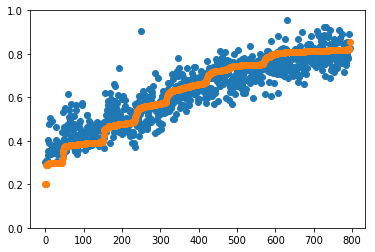

In [0]:
plt.title('Predicted vs true performance (models are sorted in increasing order)')

plt.ylim(0, 1)
plt.plot(y_pred, 'o')
# plt.show()

# plt.ylim(0, 1)
plt.plot(acc_sorted, 'o')
plt.show()